# Homework 3: CNN

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

## Objectives:


- Use CNN for image recognition
- Use CNN for text classification

## Instructions


- Check `Lab 3: Embedding` and `Lab 4: CNN` before you start working on this assignment. These labs should give you a good starting point.
- Please complete all questions using Jupyter Notebook.
- Please answer all analysis questions using Jupyter Notebook Markdowns or in a separate pdf file (if you don't know how to write Markdowns).
- Please run your Jupyter Notebook to get all training histories and plots, save the notebook to pdf file, and sumbit the pdf file along with the Jupyter Notebook


## The FashionMNIST dataset

-  `FashionMNIST`, a dataset of article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. For details, check https://github.com/zalandoresearch/fashion-mnist
- To reduce the training time, `we'll only use 6000 images for training`
- See code below to load dataset

In [1]:
#! pip install torchinfo

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [3]:
# Load dataset

train_dataset = torchvision.datasets.FashionMNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

In [4]:
# Randomly select 6000 for training

N = len(train_dataset)
train_dataset = Subset(train_dataset, np.random.choice(N, 6000, replace=False))

In [5]:
# Split dataset into training and evaluation

N = len(train_dataset)
train_size = int(0.7*N)
train_dataset, val_dataset = random_split(train_dataset,\
                                          lengths=[train_size, N - train_size])

print(f'Train dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')


Train dataset length: 4200
Validation dataset length: 1800


image tensor: torch.Size([32, 1, 28, 28])
class labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


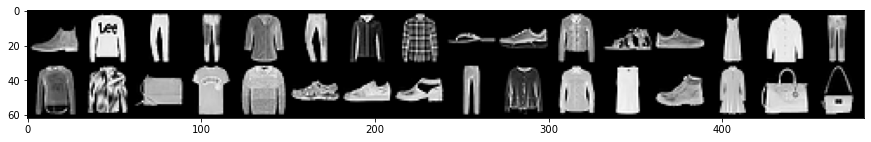

In [6]:
# Show some images from test dataset

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
imgs, labels = next(iter(test_loader))
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=16, ncols=2, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {labels}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

## Q1: Create a CNN model to classify images 

1. In HW 2, you created a linear model to classify images. In this assignment, you'll create a CNN model to classify the same dataset and compare model performance. Carefully design your model with the following layers:
    - Convolution layers with appropriate filter design (i.e., filter size and number)
    - Maxpooling layers
    - Linear layers
    - Regularizers such as dropout
<br><br>
2. Reuse the `fit_model` function in HW 2 to fit the model and plot learning curves to show evaluation loss / accuracy vs. epoches. Tune your model carefully. Your target is to achieve `a test accuracy about 87%`.
<br><br>
3.  Compare the model performance with what you achieved in HW 2 and answer the following:
    - Compare with the best performing model in HW 2, your CNN model has more or less parameters?
    - Can you briefly explain what leads to the performance improvement in the CNN model? 

In [7]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        # conv net
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (48, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(32, 14, 14)  if stride is not provided, it will default to kernel_size
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=2),  # (24, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 6, 6)        
            nn.Flatten() ,           
            nn.Dropout(0.5),
            nn.Linear(in_features = 24*6*6, out_features = 100),
            nn.Dropout(0.2),
            nn.Linear(in_features = 100, out_features = 10)
        )
       
    def forward(self, x):
        output = self.convnet(x)
    
        return output

In [9]:
class linear_model(nn.Module):
    
    # hidden_units is a list which specify the output of each layer
    def __init__(self, input_dim = 784, hidden_units=[256]):
        
        # initialize parent class
        super(linear_model, self).__init__()
        
        hidden_units = [input_dim] + hidden_units
        
        self.layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) \
                                     for i in range(len(hidden_units)-1)])
    
    def forward(self, x):
        
        output = x
        #print(x.size())
        for i, layer in enumerate(self.layers):
            
            output = layer(output)
            #print(output.size())
            
            if i<len(self.layers)-1:   # no activation on the last layer
                output = F.relu(output)
        
        return output

In [10]:
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=128):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / y.size(0)
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim = -1)
                cur_val_loss = criterion(outputs, y)
                cur_val_acc = (pred == y).sum().item() / y.size(0) 
                
                # loss and acc
                val_loss += cur_val_loss
                val_acc += cur_val_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (val_loss/len(val_loader)).item()
        val_acc = val_acc/len(val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, valid loss:{val_loss:.3f} valid acc:{val_acc:.3f}")
    

    model.eval()
    ys = []
    preds = []

    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)

            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)

            preds.append(pred.view(-1).cpu().numpy())
            ys.append(y)

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    test_acc = (ys==preds).astype(int).sum()/len(ys)
    print(f"test acc:{test_acc:.3f}")

    return test_acc, history

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# dataset

modela = cnn_model()
summary(modela, (32, 1, 28, 28))

optimizer = torch.optim.RMSprop(modela.parameters(), lr = 0.0005)
acc_a, hista = train_model(modela, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.276 train_acc:0.553, valid loss:0.824 valid acc:0.725
Epoch:2 / 200, train loss:0.800 train_acc:0.709, valid loss:0.708 valid acc:0.711
Epoch:3 / 200, train loss:0.719 train_acc:0.735, valid loss:0.665 valid acc:0.735
Epoch:4 / 200, train loss:0.684 train_acc:0.748, valid loss:0.624 valid acc:0.753
Epoch:5 / 200, train loss:0.648 train_acc:0.762, valid loss:0.593 valid acc:0.769
Epoch:6 / 200, train loss:0.625 train_acc:0.773, valid loss:0.574 valid acc:0.785
Epoch:7 / 200, train loss:0.613 train_acc:0.764, valid loss:0.556 valid acc:0.779
Epoch:8 / 200, train loss:0.595 train_acc:0.777, valid loss:0.535 valid acc:0.804
Epoch:9 / 200, train loss:0.590 train_acc:0.780, valid loss:0.540 valid acc:0.795
Epoch:10 / 200, train loss:0.558 train_acc:0.792, valid loss:0.529 valid acc:0.803
Epoch:11 / 200, train loss:0.554 train_acc:0.800, valid loss:0.497 valid acc:0.821
Epoch:12 / 200, train loss:0.559 train_acc:0.790, valid loss:0.521 valid acc:0.80

Epoch:100 / 200, train loss:0.314 train_acc:0.883, valid loss:0.377 valid acc:0.874
Epoch:101 / 200, train loss:0.308 train_acc:0.885, valid loss:0.367 valid acc:0.869
Epoch:102 / 200, train loss:0.305 train_acc:0.888, valid loss:0.376 valid acc:0.874
Epoch:103 / 200, train loss:0.301 train_acc:0.889, valid loss:0.374 valid acc:0.870
Epoch:104 / 200, train loss:0.312 train_acc:0.886, valid loss:0.383 valid acc:0.869
Epoch:105 / 200, train loss:0.303 train_acc:0.891, valid loss:0.375 valid acc:0.869
Epoch:106 / 200, train loss:0.302 train_acc:0.890, valid loss:0.382 valid acc:0.866
Epoch:107 / 200, train loss:0.300 train_acc:0.890, valid loss:0.381 valid acc:0.865
Epoch:108 / 200, train loss:0.307 train_acc:0.887, valid loss:0.377 valid acc:0.871
Epoch:109 / 200, train loss:0.286 train_acc:0.893, valid loss:0.369 valid acc:0.870
Epoch:110 / 200, train loss:0.301 train_acc:0.890, valid loss:0.368 valid acc:0.876
Epoch:111 / 200, train loss:0.295 train_acc:0.894, valid loss:0.371 valid ac

Epoch:198 / 200, train loss:0.227 train_acc:0.919, valid loss:0.372 valid acc:0.882
Epoch:199 / 200, train loss:0.238 train_acc:0.914, valid loss:0.359 valid acc:0.884
Epoch:200 / 200, train loss:0.219 train_acc:0.920, valid loss:0.368 valid acc:0.874
test acc:0.870


In [13]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

Test acc: model A 0.870


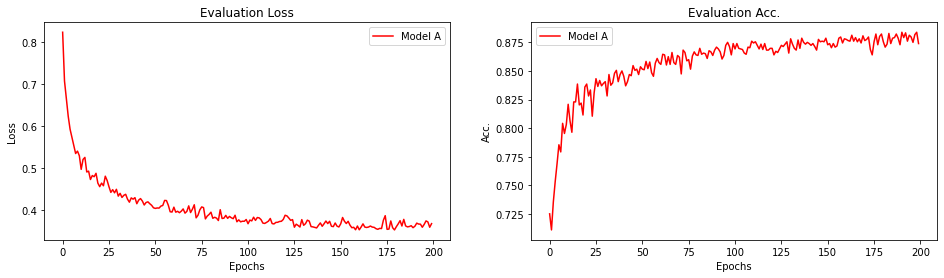

In [14]:
print(f"Test acc: model A {acc_a:.3f}")

get_plot([hista], ["Model A"], len(hista['val_loss']))

## Q2 (bonus): Further improve model performance

Can you find a way to `improve model test accuracy to above 88%`? For example, you can think about data augmentation or use pretrained image classification models.
<br><br>
Implement the techiques you take, plot the model evaluation loss / accuracy vs. epoches, and compare it with the plot in Q1. Can you explain why the techniques you choose can improve model performance?

In [15]:
# dataset with augmentation

class Fashion_Dataset(Dataset):
    def __init__(self, dataset, transformer = None):
        
        self.dataset = dataset
        
        self.transformer = transformer
    
    def __getitem__(self, index):
        # load image
        
        img, label = self.dataset[index]
        if self.transformer:
            img = self.transformer(img)
       
        return img, label
    
    def __len__(self):
        return len(self.dataset)  
    
    
def show_img(img):
    plt.figure(figsize=(5,4))  
    plt.imshow(np.transpose(img, axes=(1,2,0)), cmap="gray")

In [16]:
# data augmentation

transform = transforms.Compose([
            transforms.GaussianBlur(1),
            transforms.RandomResizedCrop((28,28), scale=(0.9, 1.1))
            ])


In [17]:
fashion_dataset = Fashion_Dataset(train_dataset, transformer = transform)
len(fashion_dataset)

4200

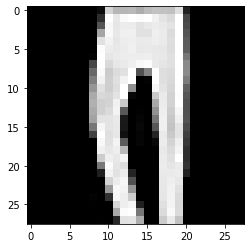

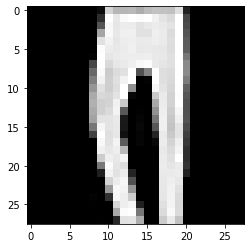

In [18]:
# Test transformation
imgs, labels = train_dataset[0]
show_img(imgs)
# #x = imgs.view(1, *imgs.size())
# #x.size()

imgs, label = fashion_dataset[0]
show_img(imgs)

In [19]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.RMSprop(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.322 train_acc:0.513, valid loss:0.770 valid acc:0.718
Epoch:2 / 200, train loss:0.823 train_acc:0.698, valid loss:0.663 valid acc:0.765
Epoch:3 / 200, train loss:0.721 train_acc:0.730, valid loss:0.622 valid acc:0.757
Epoch:4 / 200, train loss:0.657 train_acc:0.750, valid loss:0.561 valid acc:0.787
Epoch:5 / 200, train loss:0.644 train_acc:0.765, valid loss:0.525 valid acc:0.804
Epoch:6 / 200, train loss:0.631 train_acc:0.765, valid loss:0.526 valid acc:0.803
Epoch:7 / 200, train loss:0.614 train_acc:0.771, valid loss:0.491 valid acc:0.817
Epoch:8 / 200, train loss:0.597 train_acc:0.783, valid loss:0.475 valid acc:0.829
Epoch:9 / 200, train loss:0.581 train_acc:0.786, valid loss:0.484 valid acc:0.814
Epoch:10 / 200, train loss:0.573 train_acc:0.790, valid loss:0.479 valid acc:0.822
Epoch:11 / 200, train loss:0.565 train_acc:0.794, valid loss:0.466 valid acc:0.829
Epoch:12 / 200, train loss:0.549 train_acc:0.798, valid loss:0.486 valid acc:0.81

Epoch:100 / 200, train loss:0.381 train_acc:0.857, valid loss:0.341 valid acc:0.872
Epoch:101 / 200, train loss:0.376 train_acc:0.864, valid loss:0.377 valid acc:0.863
Epoch:102 / 200, train loss:0.364 train_acc:0.864, valid loss:0.362 valid acc:0.864
Epoch:103 / 200, train loss:0.376 train_acc:0.860, valid loss:0.337 valid acc:0.870
Epoch:104 / 200, train loss:0.381 train_acc:0.857, valid loss:0.355 valid acc:0.879
Epoch:105 / 200, train loss:0.374 train_acc:0.859, valid loss:0.364 valid acc:0.871
Epoch:106 / 200, train loss:0.378 train_acc:0.865, valid loss:0.348 valid acc:0.870
Epoch:107 / 200, train loss:0.368 train_acc:0.863, valid loss:0.342 valid acc:0.874
Epoch:108 / 200, train loss:0.354 train_acc:0.866, valid loss:0.369 valid acc:0.862
Epoch:109 / 200, train loss:0.365 train_acc:0.861, valid loss:0.355 valid acc:0.867
Epoch:110 / 200, train loss:0.368 train_acc:0.865, valid loss:0.345 valid acc:0.874
Epoch:111 / 200, train loss:0.356 train_acc:0.864, valid loss:0.339 valid ac

Epoch:198 / 200, train loss:0.316 train_acc:0.883, valid loss:0.314 valid acc:0.883
Epoch:199 / 200, train loss:0.318 train_acc:0.885, valid loss:0.319 valid acc:0.880
Epoch:200 / 200, train loss:0.323 train_acc:0.878, valid loss:0.348 valid acc:0.874
test acc:0.870


In [20]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.Adam(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.723 train_acc:0.412, valid loss:0.915 valid acc:0.679
Epoch:2 / 200, train loss:0.891 train_acc:0.670, valid loss:0.713 valid acc:0.726
Epoch:3 / 200, train loss:0.746 train_acc:0.718, valid loss:0.618 valid acc:0.781
Epoch:4 / 200, train loss:0.684 train_acc:0.738, valid loss:0.575 valid acc:0.795
Epoch:5 / 200, train loss:0.655 train_acc:0.759, valid loss:0.559 valid acc:0.799
Epoch:6 / 200, train loss:0.630 train_acc:0.772, valid loss:0.545 valid acc:0.794
Epoch:7 / 200, train loss:0.618 train_acc:0.769, valid loss:0.532 valid acc:0.804
Epoch:8 / 200, train loss:0.594 train_acc:0.776, valid loss:0.511 valid acc:0.818
Epoch:9 / 200, train loss:0.571 train_acc:0.794, valid loss:0.484 valid acc:0.824
Epoch:10 / 200, train loss:0.574 train_acc:0.789, valid loss:0.490 valid acc:0.819
Epoch:11 / 200, train loss:0.538 train_acc:0.809, valid loss:0.492 valid acc:0.825
Epoch:12 / 200, train loss:0.541 train_acc:0.803, valid loss:0.459 valid acc:0.83

Epoch:100 / 200, train loss:0.347 train_acc:0.870, valid loss:0.347 valid acc:0.874
Epoch:101 / 200, train loss:0.338 train_acc:0.878, valid loss:0.331 valid acc:0.879
Epoch:102 / 200, train loss:0.343 train_acc:0.871, valid loss:0.341 valid acc:0.875
Epoch:103 / 200, train loss:0.337 train_acc:0.876, valid loss:0.336 valid acc:0.880
Epoch:104 / 200, train loss:0.333 train_acc:0.879, valid loss:0.348 valid acc:0.869
Epoch:105 / 200, train loss:0.333 train_acc:0.878, valid loss:0.328 valid acc:0.885
Epoch:106 / 200, train loss:0.335 train_acc:0.874, valid loss:0.333 valid acc:0.880
Epoch:107 / 200, train loss:0.322 train_acc:0.879, valid loss:0.346 valid acc:0.880
Epoch:108 / 200, train loss:0.333 train_acc:0.877, valid loss:0.331 valid acc:0.880
Epoch:109 / 200, train loss:0.332 train_acc:0.874, valid loss:0.346 valid acc:0.873
Epoch:110 / 200, train loss:0.327 train_acc:0.883, valid loss:0.333 valid acc:0.876
Epoch:111 / 200, train loss:0.327 train_acc:0.875, valid loss:0.327 valid ac

Epoch:198 / 200, train loss:0.281 train_acc:0.902, valid loss:0.317 valid acc:0.889
Epoch:199 / 200, train loss:0.288 train_acc:0.892, valid loss:0.329 valid acc:0.882
Epoch:200 / 200, train loss:0.279 train_acc:0.891, valid loss:0.322 valid acc:0.886
test acc:0.884


Test acc: model A 0.870, model B 0.884


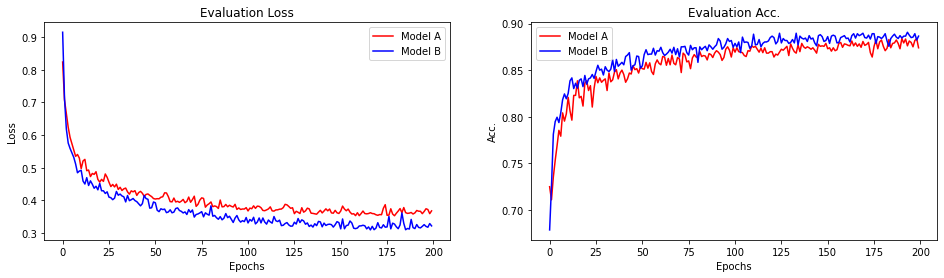

In [21]:
print(f"Test acc: model A {acc_a:.3f}, model B {acc_b:.3f}")

get_plot([hista, histb], ["Model A","Model B"], len(hista['val_loss']))

## Q3: CNN for Text Classification

In this task, we'll use CNN to detect emotion from text. The dataset is taken from https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text.


The following scripts show you how to load the data and split the samples into training, evaluation, and test.

### Load Data

In [22]:
import pandas as pd
from sklearn.utils import shuffle


In [23]:
data = pd.read_csv("Emotion_final.csv")
data.head()
len(data)

data = shuffle(data)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


21459

In [24]:
# Map text label to numbers

label_map = {'fear':0, 'happy':1, 'anger':2, 'surprise':3, 'sadness':4, 'love':5}
data["label"] = data.Emotion.apply(lambda x: label_map[x])
data.head()
data.label.value_counts()

,Text,Emotion,label
11319,i feel impatient with the christian church dis...,anger,2
793,i feel like him try to stay as faithful as pos...,happy,1
11516,im feeling pretty proud most of the elements i...,happy,1
18681,i went to bed feeling pretty proud of myself e...,happy,1
2273,i feel heartbroken mostly for my daughter and ...,sadness,4


1    7029
4    6265
2    2993
0    2652
5    1641
3     879
Name: label, dtype: int64

In [25]:
# Split dataset into training, evaluation, and test

train_data = data.iloc[0: 15000]
eval_data = data.iloc[15000: 18000]
test_data = data.iloc[18000: ]

### Q3.1. Preprocess Text

Write a function `preprocess(train_data, eval_data, test_data)` to convert the three sample subsets into three datasets so that you can use it for model fitting. 
- This function has the three sample subsets as inputs
- During preprocessing, do the following:
    1. Tokenize each document into words
    1. Map every unique word in the vocabulary into an index (i.e. `word index`)
    1. Convert each document into a sequence of word indexes with uniform length by padding short ones and truncating long ones.
    1. Create Torch datasets for the subsets that can be directly used for training
- Return the datasets and also the word-index dictionary 


When you preprocess the text, `carefully explain how you choose the following hyperparameters`:
- Vocabulary size (i.e. the total number of words)
- Maximum sentence length


Feel free to use Keras pacakage to process text (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

[]

15959

0    14985
1      486
2      165
3       70
4       48
6       27
7       20
5       18
9       12
8        9
dtype: int64

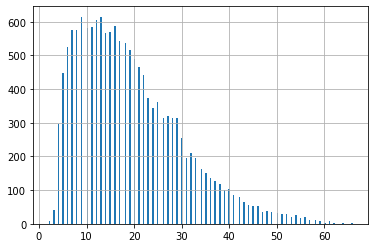

In [26]:
# A few exploration steps
from tensorflow import keras

# check document length
(train_data.apply(lambda row: len(row["Text"].split()), axis = 1)).hist(bins = 200).plot()
#(train_data.apply(lambda row: len(row["title"].split()), axis = 1)).hist(bins = 200).plot()

# check word frequencies
tokenizer = keras.preprocessing.text.Tokenizer()
#tokenizer.fit_on_texts(train_data["title"] +" "+ train_data["text"])
tokenizer.fit_on_texts(train_data["Text"])

len(tokenizer.word_counts)
word_counts = pd.Series(list(tokenizer.word_counts.values()))
(word_counts//30).value_counts().sort_values(ascending = False)[0:10]

In [27]:
class News_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]


In [28]:
def preprocess(train_data, eval_data, test_data, vocab_size = 10000, max_sent = 50):
    
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(train_data["Text"])

    train_seq = tokenizer.texts_to_sequences(train_data["Text"])
    train_seq = keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    eval_seq = tokenizer.texts_to_sequences(eval_data["Text"])
    eval_seq = keras.preprocessing.sequence.pad_sequences(eval_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    
    test_seq = tokenizer.texts_to_sequences(test_data["Text"])
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    # dataset
    train_dataset = News_dataset(train_seq, train_data["label"].values)
    eval_dataset = News_dataset(eval_seq, eval_data["label"].values)
    test_dataset = News_dataset(test_seq, test_data["label"].values)
    
    return train_dataset, eval_dataset, test_dataset, tokenizer

In [29]:
vocab_size = 10000
max_sent = 50

train_dataset, eval_dataset, test_dataset, tokenizer = preprocess(train_data, eval_data, test_data, \
                                                       vocab_size, max_sent )

In [30]:
#tokenizer.word_index

### 3.2. Load pretrained word vectors

Let's use pretrained word vectors. For every unique words you obtained from Q3.1., look up for the pretrained word vectors (e.g. Glove, Google word vector etc.), and create an embedding matrix which should have the shape of `(vacab_size, emb_dim)`. 


Hint: check `Lab 3: Embedding` for this task. You need to carefully choose the `embeding dimension`.

In [31]:
#!pip install torchtext

In [34]:
import torchtext
emb_dim = 100

vector = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:06<00:00, 64227.45it/s]


In [35]:

missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in tokenizer.word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


In [36]:
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

torch.Size([10000, 100])


### 3.3. Model

Define a CNN model for this classification task. You model should provide options to configure the following parameters:
- Embedding layer 
    - vocabulary size, embedding dimension
    - Whether to use pretrained word vectors
    - If pretrained word vectors are used, whether to freeze word vectors or allow fine-tuning of word vectors<br><br>
- Convolution layer:
    - Number of filters
    - Filter sizes


In [37]:
class cnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, num_filters,  \
                 kernel_sizes, emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(cnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.convs = nn.ModuleList([nn.Conv1d(self.emb_dim, self.num_filters, f) for f in self.kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        
        x = torch.swapaxes(x, 1, 2) # Batch x emb_dim x max_sent 

        x = [F.relu(conv(x)) for conv in self.convs]  # output of three conv, batch x num_filter x L

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  

        x = self.dropout(x)  

        logit = self.fc(x)  

        return logit

### 3.4. Train

First, carefully choose the hyperparameters for convolution layers. You can reuse the training function to train the model. Train your model with these three configuration:
- (A): Random initialize embedding layer
- (B): Initialize the embedding layer using pretrained word vectors and freeze word vectors
- (C): Initialize the embedding layer using pretrained word vectors and allow your model to fine tune word vectors
    
    
If your models are properly configured, `your test accuracy should be at least about 85% and the best performing model accuracy can be around 90%`. 


Finally, notice that you have an imbalanced dataset. To understand which classes underperform, modify the training function to print out a classification report which display the precision, recall, and f1 for each class (see function https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).



In [38]:
from sklearn.metrics import classification_report

def train_model(model, train_dataset, eval_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=64):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'eval_loss': [],
               'eval_acc': [],
               'test_acc': 0}
    
    patience = 5
    max_acc = -np.Inf
    cnt = 0
    
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                
                outputs = model(x)  # (num_batch, 45) 
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(eval_loader)).item()
        val_acc = test_acc/len(eval_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(val_loss)
        history['eval_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f},\
        train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if test_acc > max_acc:
            max_acc = test_acc
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
            
            if cnt == patience:
                print("early stopping!")
                break
    
    # restore best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history

In [39]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_acc = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)
            
            ys.append(y.cpu().numpy())
            preds.append(pred.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_acc = (preds == ys).astype(int).mean()
    print(classification_report(ys, preds))
        
    print(f"Test acc: {test_acc:.4f}")
    
    return test_acc

### Training

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
kernel_sizes = [1, 3, 5]
num_filters = 30
num_classes = 6

In [42]:
# Case A, randomly initialize embedding layer

model_cnn_a = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = None)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_a.parameters(), lr=0.0005)

model_cnn_a, hista = train_model(model_cnn_a, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_a, test_dataset)

Training Start
Epoch:1 / 100, train loss:1.6710,        train_acc:0.3111, valid loss:1.5250 valid acc:0.4027
model saved!
Epoch:2 / 100, train loss:1.5506,        train_acc:0.3746, valid loss:1.4777 valid acc:0.4435
model saved!
Epoch:3 / 100, train loss:1.4693,        train_acc:0.4206, valid loss:1.3952 valid acc:0.4840
model saved!
Epoch:4 / 100, train loss:1.3711,        train_acc:0.4806, valid loss:1.2609 valid acc:0.5540
model saved!
Epoch:5 / 100, train loss:1.2243,        train_acc:0.5505, valid loss:1.0681 valid acc:0.6464
model saved!
Epoch:6 / 100, train loss:1.0456,        train_acc:0.6287, valid loss:0.8749 valid acc:0.7203
model saved!
Epoch:7 / 100, train loss:0.8672,        train_acc:0.6977, valid loss:0.6988 valid acc:0.7660
model saved!
Epoch:8 / 100, train loss:0.7045,        train_acc:0.7680, valid loss:0.5657 valid acc:0.8267
model saved!
Epoch:9 / 100, train loss:0.5969,        train_acc:0.8032, valid loss:0.4825 valid acc:0.8461
model saved!
Epoch:10 / 100, train 

In [43]:
# Case B: Use word vectors and freeze word vectors
model_cnn_b = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = True)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_b.parameters(), lr=0.0005)

model_cnn_b, hist_b = train_model(model_cnn_b, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_b, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5094,        train_acc:0.4218, valid loss:1.2683 valid acc:0.5615
model saved!
Epoch:2 / 100, train loss:1.1600,        train_acc:0.5914, valid loss:0.9649 valid acc:0.6811
model saved!
Epoch:3 / 100, train loss:0.9656,        train_acc:0.6575, valid loss:0.8122 valid acc:0.7456
model saved!
Epoch:4 / 100, train loss:0.8443,        train_acc:0.6988, valid loss:0.7100 valid acc:0.7723
model saved!
Epoch:5 / 100, train loss:0.7718,        train_acc:0.7269, valid loss:0.6443 valid acc:0.7976
model saved!
Epoch:6 / 100, train loss:0.7101,        train_acc:0.7535, valid loss:0.5920 valid acc:0.8102
model saved!
Epoch:7 / 100, train loss:0.6714,        train_acc:0.7679, valid loss:0.5550 valid acc:0.8199
model saved!
Epoch:8 / 100, train loss:0.6307,        train_acc:0.7814, valid loss:0.5366 valid acc:0.8286
model saved!
Epoch:9 / 100, train loss:0.6075,        train_acc:0.7893, valid loss:0.5080 valid acc:0.8359
model saved!
Epoch:10 / 100, train 

In [44]:
# Case C: Use word vectors and allow fine tuning

model_cnn_c = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = False)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_c.parameters(), lr=0.0005)

model_cnn_c, hist_c = train_model(model_cnn_c, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_c, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5117,        train_acc:0.4181, valid loss:1.2247 valid acc:0.5740
model saved!
Epoch:2 / 100, train loss:0.9903,        train_acc:0.6664, valid loss:0.6625 valid acc:0.8020
model saved!
Epoch:3 / 100, train loss:0.5753,        train_acc:0.8143, valid loss:0.3806 valid acc:0.8741
model saved!
Epoch:4 / 100, train loss:0.3875,        train_acc:0.8732, valid loss:0.2774 valid acc:0.8985
model saved!
Epoch:5 / 100, train loss:0.3078,        train_acc:0.8975, valid loss:0.2338 valid acc:0.9101
model saved!
Epoch:6 / 100, train loss:0.2586,        train_acc:0.9118, valid loss:0.2127 valid acc:0.9138
model saved!
Epoch:7 / 100, train loss:0.2258,        train_acc:0.9195, valid loss:0.2023 valid acc:0.9138
Epoch:8 / 100, train loss:0.2136,        train_acc:0.9269, valid loss:0.2001 valid acc:0.9158
model saved!
Epoch:9 / 100, train loss:0.1884,        train_acc:0.9322, valid loss:0.1946 valid acc:0.9168
model saved!
Epoch:10 / 100, train loss:0.1785, 